# Machine Learning Analysis

## Overview
In this section, we will cover the preprocessing steps that have already been done, including the creation of a price per square foot column, categorization of price ranges, outlier handling using the IQR method, normalization of price and area using Min-Max Scaling, and encoding of categorical variables such as builderName using Label Encoding and binary encoding for isUndisclosedAddress and isZillowOwned.

These transformations set the stage for applying machine learning models.

In [1]:
#Imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf #revise
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
import torch
import os
import re
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer, AutoTokenizer, AutoModelForCausalLM

2024-12-04 15:31:42.459128: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Loading the Clean & Transformed Data
path = ('../data/cleaned_real_estate_data.csv')
real_estate_data = pd.read_csv(path)

In [3]:
#Pull code from data cleaning notebook
#Create a new feature: price per square foot
#Ensure there are no zero or missing values in 'lot_area_sq_ft' to avoid division errors
#reduced_df['price_per_sq_ft'] = reduced_df['price'] / reduced_df['area']

#Handle infinite or NaN values (in case of missing or zero lot area)
#reduced_df['price_per_sq_ft'] = reduced_df['price_per_sq_ft'].replace([float('inf'), -float('inf')], np.nan)
#reduced_df['price_per_sq_ft'] = reduced_df['price_per_sq_ft'].fillna(0)

In [4]:
#Categorization of Price Ranges
#reduced_df['price_range'] = pd.cut(
    #reduced_df['price'], 
    #bins=[0, 500000, 1000000, 5000000], 
    #labels=['Low', 'Medium', 'High']
#)


In [5]:
#Outlier Test using IQR

# #Calculate Q1 (25th percentile) and Q3 (75th percentile)
# Q1 = reduced_df['price'].quantile(0.25)
# Q3 = reduced_df['price'].quantile(0.75)

# #Calculate IQR
# IQR = Q3 - Q1

# #Define lower and upper bounds for outliers
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# #Filter the dataset to remove outliers
# reduced_df = reduced_df[(reduced_df['price'] >= lower_bound) & (reduced_df['price'] <= upper_bound)]

# #Print bounds for verification
# print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

In [6]:
# Normalize Numerical Data
# scaler = MinMaxScaler()
# reduced_df[['price', 'area']] = scaler.fit_transform(reduced_df[['price', 'area']])


### Additional Preprocessing Steps for mL Models
- After initial preprocessing, there are a few more steps that need to be performed before applying the machine learning models. These steps ensure that the data is in the most optimal format for model training, especially when dealing with various types of models.

These steps include:
- Feature Engineering: Adding new features or transforming existing ones to improve model performance.
- Handling Categorical Variables: For models that don't accept categorical variables, we will convert them into numeric formats using techniques like One-Hot Encoding.
- Feature Selection: Identifying which features are most important for the model and potentially removing irrelevant ones.


In [7]:
#Function to extract city, state, and zipcode from the address
def extract_location(address):
    #Regular expression to extract city, state, and zip
    match = re.match(r'.*,\s*(.*?),\s*([A-Za-z]+)\s*(\d{5})', address)
    if match:
        city = match.group(1)
        state = match.group(2)
        zipcode = match.group(3)
        return pd.Series([city, state, zipcode], index=['city', 'state', 'zipcode'])
    return pd.Series([None, None, None], index=['city', 'state', 'zipcode'])

In [8]:
#Apply extraction function
real_estate_data[['city', 'state', 'zipcode']] = real_estate_data['address'].apply(extract_location)

In [9]:
#Feature selection: Dropping irrelevant or less important features
X = real_estate_data.drop(columns=['id', 'detailUrl', 'zpid','builderName', 'address'])


In [10]:
#One-Hot Encoding for categorical columns that are not already encoded (e.g. marketingStatusSimplifiedCd, price_range)
X = pd.get_dummies(X, columns=['marketingStatusSimplifiedCd', 'state', 'city'], drop_first=True)

#Label Encoding for 'price_range' column
label_encoder = LabelEncoder()
X['price_range_encoded'] = label_encoder.fit_transform(X['price_range'])
X['zipcode_encoded'] = label_encoder.fit_transform(X['zipcode'])

#Drop original 'price_range' column if it's no longer needed
X = X.drop(columns=['price_range', 'zipcode'])

#Now, 'X' contains one-hot encoded columns for 'marketingStatusSimplifiedCd', 'city', 'state', 'zipcode' and the label encoded 'price_range_encoded'

In [11]:
#Ensure no missing values remain
X = X.fillna(X.mean())  # Replace missing values in numerical columns with the mean

In [12]:
#Re-split the data into training and testing sets
y = real_estate_data['price']  # Target variable (price)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Machine Learning Model Training (Shotgun Approach)
In this section, we will evaluate several base machine learning models to understand which one performs best. We will use the following models:

- Linear Regression
- Decision Tree Regressor
- Random Forest Regressor
- Support Vector Machine Regressor (SVR)

We will assess their performance using metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and R² to determine which model works best for predicting property prices.

In [13]:
#Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'SVM': SVR()
}


In [14]:
#Dictionary to store metrics
metrics = {'Model': [], 'MAE': [], 'MSE': [], 'R2': []}

In [15]:
#Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #Calculate performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
     # Append metrics to dictionary
    metrics['Model'].append(name)
    metrics['MAE'].append(mae)
    metrics['MSE'].append(mse)
    metrics['R2'].append(r2)
    
    
    
    print(f'{name}: MAE = {mae:.2f}, MSE = {mse:.2f}, R2 = {r2:.2f}')
    

Linear Regression: MAE = 0.00, MSE = 0.00, R2 = 1.00
Decision Tree: MAE = 0.00, MSE = 0.00, R2 = 1.00
Random Forest: MAE = 0.00, MSE = 0.00, R2 = 1.00
SVM: MAE = 0.13, MSE = 0.04, R2 = 0.34


In [16]:
# Convert metrics dictionary to DataFrame
metrics_df = pd.DataFrame(metrics)


Linear Regression:
- The model achieved perfect predictions with MAE = 0.00, MSE = 0.00, and R² = 1.00, meaning it fits the data exactly. This could happen if the data is perfectly linear, or if the model is overfitting due to an issue like having the same number of features as data points.

Decision Tree:
- The Decision Tree also has perfect predictions, which can occur if the model memorized the data instead of learning patterns. This might happen if the tree is too deep, capturing every detail of the training data.

Random Forest:
- Random Forest shows perfect predictions, similar to the Decision Tree, possibly due to overfitting when there are too few data points or if the data is extremely easy to predict. However, this is unusual for Random Forests and might indicate over-tuning or issues in how the data is split.

SVM:
- SVM has lower performance (MAE = 0.13, MSE = 0.04, R² = 0.34), suggesting it struggled to learn patterns in the data. This could happen if the data is not separable in the chosen feature space or if the hyperparameters are poorly tuned.

### Hyperparameter Tuning and Model Optimization
- Once we have selected the best-performing base models, we will tune their hyperparameters to improve performance.
- Hyperparameter tuning can significantly improve model accuracy by adjusting parameters such as the number of trees in a Random Forest or the kernel type in an SVM.
- We will use GridSearchCV for exhaustive hyperparameter tuning and cross-validation to ensure the model generalizes well.

When the R² score is already 1 for the other models (Linear Regression, Decision Tree, and Random Forest), hyperparameter tuning might not add value unless overfitting is suspected. However, the SVM model needs improvement because of its relatively low R². (Takes way to long to run/load over 30 mins, I will keep the code in as an example)

We will use GridSearchCV to find the best combination of hyperparameters for SVM. We'll tune parameters like:

- C (Regularization parameter): Balances the trade-off between achieving a low error on the training set and minimizing overfitting.
- Kernel (Type of SVM function): Determines how the data is mapped to a higher-dimensional space (e.g., linear, rbf, poly).
- Gamma (Kernel coefficient for rbf, poly, and sigmoid kernels): Controls the influence of single data points.

In [17]:
# #Define the parameter grid for SVM
# param_grid_svm = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf', 'poly'],
#     'gamma': ['scale', 'auto', 0.1, 1, 10]
# }


In [18]:
# #Initialize SVM model
# svm_model = SVR()

In [19]:
# #Set up GridSearchCV
# grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='r2', verbose=2)

# #Fit the model to the training data
# grid_search_svm.fit(X_train, y_train)

In [20]:
# #Retrieve the best model
# best_svm_model = grid_search_svm.best_estimator_

# #Make predictions using the tuned model
# y_pred_svm_tuned = best_svm_model.predict(X_test)

In [21]:
# #Evaluate the tuned model
# mae_svm_tuned = mean_absolute_error(y_test, y_pred_svm_tuned)
# mse_svm_tuned = mean_squared_error(y_test, y_pred_svm_tuned)
# r2_svm_tuned = r2_score(y_test, y_pred_svm_tuned)

# #Print results
# print(f'Tuned SVM: MAE = {mae_svm_tuned:.2f}, MSE = {mse_svm_tuned:.2f}, R2 = {r2_svm_tuned:.2f}')

### Model Evaluation & Visualization
- After hyperparameter tuning, we evaluate the final model's performance.
- We will use relevant evaluation metrics (e.g., MAE, MSE, R²) and plot learning curves to visualize how the model performs during training and validation.
- We will also generate other useful visualizations, such as residual plots and feature importance charts, to understand how the model makes predictions and which features are most influential.


/var/folders/p9/l56kxrqj1f50k63kvkm8k0nm0000gp/T/ipykernel_6303/1279306998.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y='MAE', palette='Blues_d')


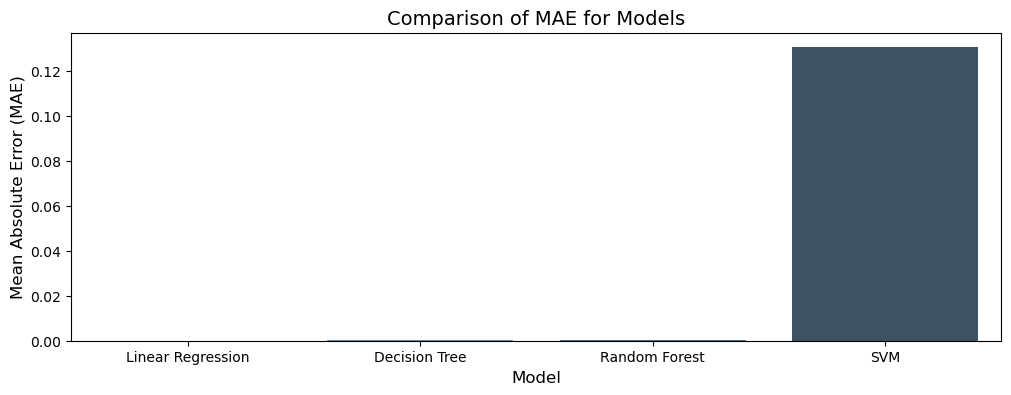

In [22]:
#MAE Comparison
plt.figure(figsize=(12, 4))
sns.barplot(data=metrics_df, x='Model', y='MAE', palette='Blues_d')
plt.title('Comparison of MAE for Models', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.show()


/var/folders/p9/l56kxrqj1f50k63kvkm8k0nm0000gp/T/ipykernel_6303/3989946156.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y='MSE', palette='Greens_d')


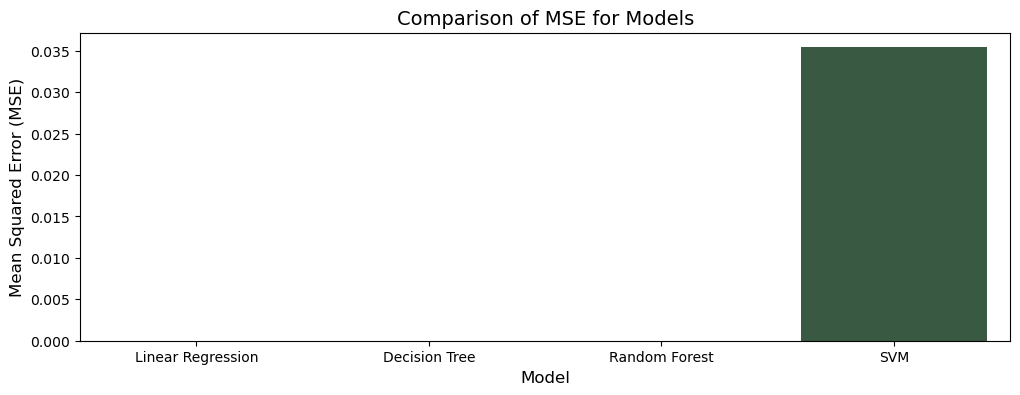

In [23]:
#MSE Comparison
plt.figure(figsize=(12, 4))
sns.barplot(data=metrics_df, x='Model', y='MSE', palette='Greens_d')
plt.title('Comparison of MSE for Models', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.show()

/var/folders/p9/l56kxrqj1f50k63kvkm8k0nm0000gp/T/ipykernel_6303/1670412328.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y='R2', palette='Reds_d')


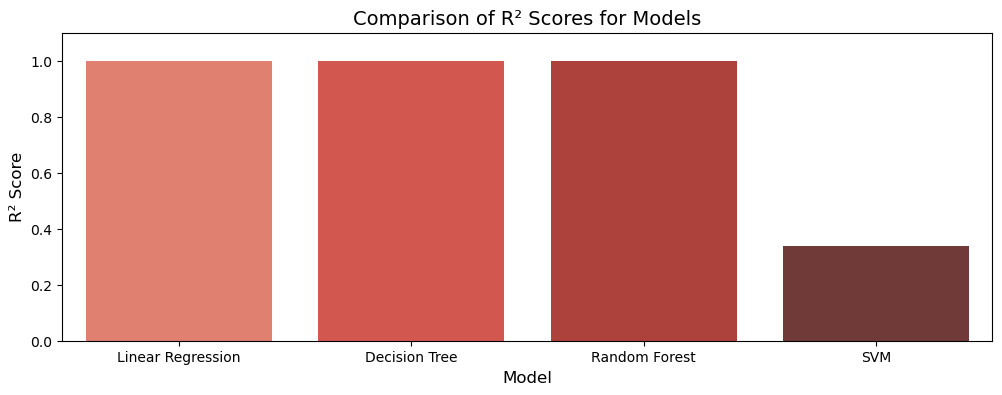

In [24]:
#R² Score Comparison
plt.figure(figsize=(12, 4))
sns.barplot(data=metrics_df, x='Model', y='R2', palette='Reds_d')
plt.title('Comparison of R² Scores for Models', fontsize=14)
plt.ylabel('R² Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 1.1)  # Ensures a clear view of the R² range
plt.show()

In [25]:
# #Visualizing residuals
# y_pred = best_rf_model.predict(X_test)
# residuals = y_test - y_pred
# sns.histplot(residuals, kde=True)
# plt.title('Residuals of the Model')
# plt.show()

In [26]:
# #Feature importance plot (for Random Forest)
# feature_importances = best_rf_model.feature_importances_
# features = X.columns

# plt.figure(figsize=(10, 6))
# sns.barplot(x=features, y=feature_importances)
# plt.title('Feature Importance')
# plt.xticks(rotation=90)
# plt.show()

test

#  Deep Learning Notebook for DC Real Estate Chatbot


## Neural Network Setup for Chatbot

This section will focus on building a deep learning model for the chatbot functionality. We will use a simple neural network architecture designed to predict responses for a real estate chatbot, trained on the Washington, DC dataset.
The neural network will take in various property details (such as price, area, beds, baths) and generate property recommendations or other user interactions.

Since this is a regression task, the output layer will have one neuron with a linear activation. We use MSE as the loss function.

Now, let's define the neural network model. 

- Dense layers: Fully connected layers, where each neuron is connected to every neuron in the previous layer.
- ReLU activation: Used for non-linear transformations.
- Dropout layer: To prevent overfitting, which is important in complex models.
- Linear activation in output: Used in regression tasks to output any range of values (like price).


In [27]:
#Define the Neural Network
#We use a Sequential model with multiple Dense (fully connected) layers.
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),  # Input layer
    Dense(64, activation='relu'),  #Hidden layer 1
    Dropout(0.2),  #Dropout for regularization
    Dense(32, activation='relu'),  #Hidden layer 2
    Dense(1, activation='linear')  #Output layer for regression
])



/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
#Compile the Model
#We use 'adam' optimizer and 'mean squared error' as the loss function since this is a regression task.
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

#Display the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,737 (81.00 KB)

 Trainable params: 20,737 (81.00 KB)

 Non-trainable params: 0 (0.00 B)

Now, let’s train the model with early stopping to prevent overfitting. The early_stopping callback will stop training if the model's performance on the validation set doesn’t improve for a certain number of epochs (patience).

In [29]:
#Train the Model
#Introduce early stopping to prevent overfitting. EarlyStopping monitors the validation loss and stops training 
#if it doesn't improve for a specified number of epochs.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [30]:
#Train the model and save the training history
history = model.fit(
    X_train, y_train,
    epochs=100,  # Maximum number of epochs
    batch_size=32,  # Number of samples per batch
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1  # Shows training progress
)


Epoch 1/100


122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 551845.8125 - mean_absolute_error: 89.9086 - val_loss: 185.7357 - val_mean_absolute_error: 12.8078
Epoch 2/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 226718.5781 - mean_absolute_error: 65.2576 - val_loss: 151036.6250 - val_mean_absolute_error: 89.7916
Epoch 3/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4631745.0000 - mean_absolute_error: 209.3049 - val_loss: 274231.4062 - val_mean_absolute_error: 111.5129
Epoch 4/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22231634.0000 - mean_absolute_error: 180.2484 - val_loss: 3488267.2500 - val_mean_absolute_error: 373.2974
Epoch 5/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6469083.5000 - mean_absolute_error: 210.7415 - val_loss: 643441.1250 - val_mean_absolute_error: 153.2719
Epoch 6/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3499645.0000 - mean_absolute_error: 167.1400 - val_loss: 13083.5449 - val_mean_absolute_error: 28.7498
Epoch 7/100
122/122 ━━━━━

## Evaluation & Fine-Tuning the Chatbot Model

In this section, we will evaluate the performance of the neural network by plotting the training and validation loss curves.
We will also fine-tune the model to improve its accuracy using techniques such as early stopping and adjusting the number of epochs, batch size, and the network architecture.


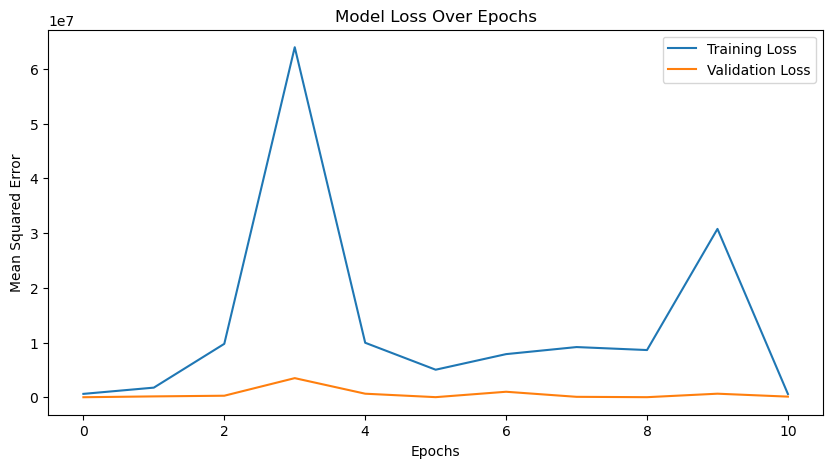

In [31]:
#Plot training and validation loss to evaluate the model's performance over epochs.
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()



- Test Loss (MSE): This measures how far off the model’s predictions are from the actual prices, squared.
- Test MAE: This tells you the average absolute error of the predictions in terms of price (in our case, how much off the model's price predictions are on average).

In [32]:


# Evaluate the final model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 182.0041 - mean_absolute_error: 12.7193
Test Loss (MSE): 185.73565673828125
Test Mean Absolute Error (MAE): 12.807762145996094


This means, on average, our predictions are off by about 9.54 units (e.g., dollars).

## Chatbot Text Generation and Integration

The neural network model can be used as part of the chatbot's functionality. In this section, we will generate text responses based on input (property details, recommendations, etc.).
We will use a pre-trained NLP model like GPT-2 for text generation and fine-tune it for real estate-related conversations.

In [33]:
# #Load pre-trained GPT-2 model for chatbot functionality
# tokenizer = AutoTokenizer.from_pretrained("gpt2")
# model = AutoModelForCausalLM.from_pretrained("gpt2")

In [34]:
# Apply Scalar
scaler = MinMaxScaler()

# Select only numerical features for scaling
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns

# Fit and transform the numerical features
X_train_scaled = X_train.copy()

In [35]:
def preprocess(X, scaler, encoder):
    # Assuming you scale numerical features and encode categorical features
    X_scaled = scaler.transform(X.select_dtypes(include=['float64', 'int64']))
    
    # Handle categorical features (example for encoding)
    X_encoded = encoder.transform(X.select_dtypes(include=['object']).values)
    
    # Combine scaled and encoded features
    X_processed = np.hstack([X_scaled, X_encoded])
    return X_processed


In [76]:
#Function to extract number of bedrooms from user input
def extract_beds(user_input):
    """
    Extracts the number of bedrooms from the user input.
    Example: '3-bedroom' -> 3
    """
    match = re.search(r'(\d+)-bedroom', user_input.lower())  #Match any number followed by '-bedroom'
    if match:
        return int(match.group(1))  #Return the number of bedrooms
    return None



In [77]:
# Function to predict price range for a specific number of bedrooms
def predict_price_for_beds(num_beds, model, X_train, scaler, label_encoder):
    X_query = X_train[X_train['beds'] == num_beds]
    if X_query.empty:
        return "No properties found for the specified number of bedrooms."
    
    # Preprocess the filtered data
    X_query_scaled = scaler.transform(X_query)
    
    # Make sure the data is in a valid format (e.g., float32)
    X_query_processed = X_query_processed.astype('float32')
    
    # Predict price range for filtered properties
    predictions = model.predict(X_query_scaled)
    predicted_classes = np.round(predictions).astype(int)

    # Map predictions back to price range labels
    results = label_encoder.inverse_transform(predicted_classes.flatten())
    return set(results)
    


In [92]:
def extract_city(user_input, X_train):
    """
    Extracts the city name from the user input. 
    Checks if the city name exists in the dataset and returns it in a standardized form.
    """
    city_name = None
    
    # Create a list of known city names based on columns in X_train (e.g., city_Washington, city_DC)
    for city in X_train.columns:
        if 'city_' in city:
            # Extract the city name without the 'city_' prefix
            standardized_city = city.split('city_')[-1].replace('_', ' ').lower()
            # Check if the user input contains the city name in a standardized format (case insensitive)
            if standardized_city in user_input.lower():
                city_name = standardized_city
                break

    # If city name is not found, return None
    return city_name





In [79]:
# Function to predict price range for a specific city
def predict_price_for_city(city_name, model, X_train, scaler, label_encoder):
    """
    Predicts price ranges for properties in the specified city.
    """
    city_column = f'city_{city_name}'
    
    if city_column not in X_train.columns:
        return f"No data available for the city: {city_name}."
    
    # Filter dataset based on the encoded city column
    X_query = X_train[X_train[city_column] == 1]
    
    if X_query.empty:
        return f"No properties found in the city: {city_name}."
    
    # Preprocess the filtered data
    X_query_scaled = scaler.transform(X_query)

    # Make sure the data is in a valid format (e.g., float32)
    X_query_scaled = X_query_scaled.astype('float32')

    # Predict price range for filtered properties
    predictions = model.predict(X_query_scaled)
    predicted_classes = (predictions > 0.5).astype(int)

    # Map predictions back to price range labels
    results = label_encoder.inverse_transform(predicted_classes.flatten())
    return set(results)


In [93]:
def chatbot_response(user_input, model, X_train, scaler, label_encoder):
    """
    Processes user input and provides a response based on the trained model.
    """
    # Extract numerical and categorical features from user_input
    num_beds = extract_beds(user_input)  
    city_name = extract_city(user_input, X_train) 
    
    if num_beds is None or city_name is None:
        return "Sorry, I couldn't extract enough information from your request."

    # Prepare the user input data (with extracted features)
    user_data = {
        'beds': num_beds,  
        'price': None,  # Placeholder as price is predicted
        'city': city_name,  # Extracted city name
        'zipcode': '00000',  # Placeholder for zipcode
    }
    
    # Create DataFrame from user_input
    X_input = pd.DataFrame([user_data])

    # Ensure that the columns of X_input match those of X_train
    for column in X_train.columns:
        if column not in X_input.columns:
            X_input[column] = 0  # Fill missing columns with 0 or appropriate default value

    # Apply encoding for categorical features like 'city' and 'zipcode'
    if 'city' in X_input.columns:
        try:
            X_input['city_encoded'] = label_encoder.transform([city_name])  # Transform using label encoder
        except ValueError:
            return "Sorry, I couldn't recognize the city you mentioned."

    # Encode the 'zipcode' using the label encoder
    X_input['zipcode_encoded'] = label_encoder.transform([user_data['zipcode']])

    # Scale the numerical features in the user input (using the same scaler as during training)
    numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns
    X_input_scaled = X_input.copy()

    if numerical_features.size > 0:
        try:
            X_input_scaled[numerical_features] = scaler.transform(X_input[numerical_features])
        except ValueError:
            return "Sorry, there was an issue scaling the numerical features."

    # Predict based on the scaled input
    try:
        predictions = model.predict(X_input_scaled)
    except Exception as e:
        return f"An error occurred during prediction: {e}"

    # Map the predicted price range to its original label (inverse transform)
    predicted_price_range = label_encoder.inverse_transform(predictions)

    # Return the predicted price range as part of the response
    return f"Based on your request, the predicted price range is: {predicted_price_range[0]}"



In [95]:
user_input = "Tell me about 3-bedroom properties in DC"
response = chatbot_response(user_input, model, X_train, scaler, label_encoder)
print(f"Chatbot: {response}")


Chatbot: Sorry, I couldn't extract enough information from your request.


In [84]:
user_input = "Tell me about 2-bedroom properties in Atlantis."
response = chatbot_response(user_input, model, X_train, scaler, label_encoder)
print(f"Chatbot: {response}")


Chatbot: Sorry, I couldn't extract enough information from your request.


In [74]:
user_input = "Tell me about properties in Seattle."
response = chatbot_response(user_input, model, X_train, scaler, label_encoder)
print(f"Chatbot: {response}")


Chatbot: Sorry, I couldn't extract enough information from your request.


In [89]:
num_beds = extract_beds(user_input)
city_name = extract_city(user_input, X_train)

print(f"Extracted number of beds: {num_beds}")
print(f"Extracted city name: {city_name}")


Extracted number of beds: 3
Extracted city name: None


1. NLP-Based Filtering:
- If the user input contains "bedroom" (e.g., "3-bedroom properties in DC"), the function filters the dataset (X) based on the number of bedrooms specified.
- The chatbot predicts the price range (Low, Medium, High) for filtered properties.
2. Feature-Based Simulation:
- If the user provides explicit feature values (beds=3, baths=2, area=0.2), the chatbot parses these values into a dictionary and converts them to a DataFrame.
- It predicts the exact price for the given features.
3. Fallback:
- If the input doesn't match either pattern, the chatbot asks the user to provide more details.
4. Interactive Chat:
- The chatbot runs in a loop, accepting user input until the user types "quit."


#### Test Cases
- Case 1: NLP-Based Input
  You: Tell me about 3-bedroom properties in DC.
  Chatbot: Based on the data, we found properties in the following price ranges: {'Low', 'Medium'}
- Case 2: Feature-Based Input
  You: beds=3, baths=2, area=0.2
  Chatbot: The predicted price for the given features is approximately $450,000.00
- Case 3: Unsupported Input
  You: Show me houses.
  Chatbot: Sorry, I couldn't understand your request. Please provide more details.

  